In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import xtrack as xt
import numpy as np
import mplcursors
import matplotlib.patches as patches
import matplotlib.ticker as ticker

# Extent functions

In [2]:
def get_ellipse_x_extent(el):
    if (np.abs(el._cos_rot_s) > 1 and np.abs(el._sin_rot_s) > 1) or (np.abs(el._sin_rot_s) < 0.00001):
        return -el.a + el.shift_x, el.a + el.shift_x
    
    else:
        t_max = np.arctan(-el.b/el.a * el._sin_rot_s/el._cos_rot_s)
        ext = el.a*np.cos(t_max)*el._cos_rot_s-el.b*np.sin(t_max)*el._sin_rot_s
        
        if ext < 0: 
            print('ERROR: ellipse extent is negatif')
            
        return -np.abs(ext) + el.shift_x, np.abs(ext) + el.shift_x
    
def get_rectangle_x_extent(el):
    if (np.abs(el._cos_rot_s) > 1 and np.abs(el._sin_rot_s) > 1) or (np.abs(el._sin_rot_s) < 0.00001):
        return el.min_x+ el.shift_x, el.max_x + el.shift_x
    else:
        w, h = el.max_x-el.min_x, el.max_y-el.min_y
        corners = np.array([[-w/2, -h/2],
                            [w/2, -h/2],
                            [w/2, h/2],
                            [-w/2, h/2]])
        
        rotation_matrix = np.array([
            [el._cos_rot_s, -el._sin_rot_s],
            [el._sin_rot_s,  el._cos_rot_s]
        ])
        
        rotated_corners = corners @ rotation_matrix.T
        
        min_x_val = np.min(rotated_corners[:,0])
        max_x_val = np.max(rotated_corners[:,0])
        
        return min_x_val + el.shift_x, max_x_val + el.shift_x
    
def get_rectellipse_x_extent(el):
    if (np.abs(el._cos_rot_s) > 1 and np.abs(el._sin_rot_s) > 1) or (np.abs(el._sin_rot_s) < 0.00001):
        ext = np.min([el.a, el.max_x])
        
        if ext < 0: 
            print('ERROR: ellipse extent is negatif')
        
        return -np.abs(ext) + el.shift_x, np.abs(ext) + el.shift_x
    
    else:
        #ellipse part
        t_max = np.arctan(-el.b/el.a * el._sin_rot_s/el._cos_rot_s)
        ext_ellipse = np.abs(el.a*np.cos(t_max)*el._cos_rot_s-el.b*np.sin(t_max)*el._sin_rot_s)
        
        #rectangle part
        corners = np.array([[-el.max_x, -el.max_y],
                            [el.max_x, -el.max_y],
                            [el.max_x, el.max_y],
                            [-el.max_x, el.max_y]])
    
        rotation_matrix = np.array([
            [el._cos_rot_s, -el._sin_rot_s],
            [el._sin_rot_s,  el._cos_rot_s]
        ])
        
        rotated_corners = corners @ rotation_matrix.T
        ext_rect = np.max(rotated_corners[:,0])
        if ext_rect < 0:
            print("ERROR: rectangle extent from rectellipse is negatif")
        
        ext = np.min([ext_ellipse, ext_rect])
        if ext < 0:
            print("ERROR: extent from rectellipse is negatif")
        
        return -np.abs(ext) + el.shift_x, np.abs(ext) + el.shift_x

def get_racetrack_x_extent(el):
    if (np.abs(el._cos_rot_s) > 1 and np.abs(el._sin_rot_s) > 1) or (np.abs(el._sin_rot_s) < 0.00001):
        return get_rectangle_x_extent(el)
    
    else:
        rotation_matrix = np.array([
                [el._cos_rot_s, -el._sin_rot_s],
                [el._sin_rot_s,  el._cos_rot_s]
            ])
        
        ellipse_centers = np.array([[el.min_x+el.a, el.min_y+el.b],
                                    [el.max_x -el.a, el.min_y + el.b],
                                    [el.max_x - el.a, el.max_y - el.b],
                                    [el.min_x + el.a, el.max_y - el.b]])
        
        ellipse_centers_rot = ellipse_centers @ rotation_matrix.T
        ellipses = np.array([xt.LimitEllipse(a= el.a, b=el.b, shift_x = ellipse_centers_rot[i,0], shift_y = ellipse_centers_rot[i,1], _cos_rot_s = el._cos_rot_s, _sin_rot_s = el._sin_rot_s) for i in range(4)])
        
        x_exts = []
        for ellipse in ellipses:
            x_min, x_max = get_ellipse_x_extent(ellipse)
            x_exts.append(np.array([x_min, x_max]))
        
        x_exts = np.array(x_exts)
            
        return np.min(x_exts[:,0]) + el.shift_x, np.max(x_exts[:,1]) + el.shift_x

In [3]:
def get_ellipse_y_extent(el):
    if (np.abs(el._cos_rot_s) > 1 and np.abs(el._sin_rot_s) > 1) or (np.abs(el._sin_rot_s) < 0.00001):
        return -el.b + el.shift_y, el.b + el.shift_y
    
    else:
        t_max = np.arctan(el.b/el.a * el._cos_rot_s/el._sin_rot_s)
        ext = el.a*np.cos(t_max)*el._sin_rot_s + el.b*np.sin(t_max)*el._cos_rot_s
        
        if ext < 0: 
            print('ERROR: ellipse extent is negatif')
            
        return -np.abs(ext) + el.shift_y, np.abs(ext) + el.shift_y
    
def get_rectangle_y_extent(el):
    if (np.abs(el._cos_rot_s) > 1 and np.abs(el._sin_rot_s) > 1) or (np.abs(el._sin_rot_s) < 0.00001):
        return el.min_y+ el.shift_y, el.max_y + el.shift_y
    else:
        w, h = el.max_x-el.min_x, el.max_y-el.min_y
        corners = np.array([[-w/2, -h/2],
                            [w/2, -h/2],
                            [w/2, h/2],
                            [-w/2, h/2]])
        
        rotation_matrix = np.array([
            [el._cos_rot_s, -el._sin_rot_s],
            [el._sin_rot_s,  el._cos_rot_s]
        ])
        
        rotated_corners = corners @ rotation_matrix.T
        
        min_y_val = np.min(rotated_corners[:,1])
        max_y_val = np.max(rotated_corners[:,1])
        
        return min_y_val + el.shift_y, max_y_val + el.shift_y
    
def get_rectellipse_y_extent(el):
    if (np.abs(el._cos_rot_s) > 1 and np.abs(el._sin_rot_s) > 1) or (np.abs(el._sin_rot_s) < 0.00001):
        ext = np.min([el.b, el.max_y])
        
        if ext < 0: 
            print('ERROR: ellipse extent is negatif')
        
        return -np.abs(ext) + el.shift_y, np.abs(ext) + el.shift_y
    
    else:
        #ellipse part
        t_max = np.arctan(el.b/el.a * el._cos_rot_s/el._sin_rot_s)
        ext_ellipse = el.a*np.cos(t_max)*el._sin_rot_s + el.b*np.sin(t_max)*el._cos_rot_s
        
        #rectangle part
        corners = np.array([[-el.max_x, -el.max_y],
                            [el.max_x, -el.max_y],
                            [el.max_x, el.max_y],
                            [-el.max_x, el.max_y]])
        
        rotation_matrix = np.array([
            [el._cos_rot_s, -el._sin_rot_s],
            [el._sin_rot_s,  el._cos_rot_s]
        ])
        
        rotated_corners = corners @ rotation_matrix.T
        ext_rect = np.max(rotated_corners[:,1])
        
        if ext_rect < 0:
            print("ERROR: rectangle extent from rectellipse is negatif")
        
        ext = np.min([ext_ellipse, ext_rect])
        if ext < 0:
            print("ERROR: extent from rectellipse is negatif")
        
        return -np.abs(ext) + el.shift_y, np.abs(ext) + el.shift_y

def get_racetrack_y_extent(el):
    if (np.abs(el._cos_rot_s) > 1 and np.abs(el._sin_rot_s) > 1) or (np.abs(el._sin_rot_s) < 0.00001):
        return get_rectangle_y_extent(el)
    
    else:
        rotation_matrix = np.array([
                [el._cos_rot_s, -el._sin_rot_s],
                [el._sin_rot_s,  el._cos_rot_s]
            ])
        
        ellipse_centers = np.array([[el.min_x+el.a, el.min_y+el.b],
                                    [el.max_x -el.a, el.min_y + el.b],
                                    [el.max_x - el.a, el.max_y - el.b],
                                    [el.min_x + el.a, el.max_y - el.b]])
        
        ellipse_centers_rot = ellipse_centers @ rotation_matrix.T
        ellipses = np.array([xt.LimitEllipse(a= el.a, b=el.b, shift_x = ellipse_centers_rot[i,0], shift_y = ellipse_centers_rot[i,1], _cos_rot_s = el._cos_rot_s, _sin_rot_s = el._sin_rot_s) for i in range(4)])
        
        y_exts = []
        for ellipse in ellipses:
            y_min, y_max = get_ellipse_y_extent(ellipse)
            y_exts.append(np.array([y_min, y_max]))
        
        y_exts = np.array(y_exts)
            
        return np.min(y_exts[:,0]) + el.shift_y, np.max(y_exts[:,1]) + el.shift_y

In [4]:
def get_x_extent(el):
    if el.__class__.__name__ == 'LimitRect':
        return get_rectangle_x_extent(el)
    
    elif el.__class__.__name__ == 'LimitEllipse':
        return get_ellipse_x_extent(el)
    
    elif el.__class__.__name__ == 'LimitRectEllipse':
        return get_rectellipse_x_extent(el)
    
    elif el.__class__.__name__ == 'LimitRacetrack':
        return get_racetrack_x_extent(el)

def get_y_extent(el):
    if el.__class__.__name__ == 'LimitRect':
        return get_rectangle_y_extent(el)
    
    elif el.__class__.__name__ == 'LimitEllipse':
        return get_ellipse_y_extent(el)
    
    elif el.__class__.__name__ == 'LimitRectEllipse':
        return get_rectellipse_y_extent(el)
    
    elif el.__class__.__name__ == 'LimitRacetrack':
        return get_racetrack_y_extent(el)

# Line elements

In [7]:
line = xt.Line.from_json('injection_thin_approx_ap2.json')
#line = xt.Line.from_json('injection.json')


tab = line.get_table()
mask = [el.startswith('Limit') for el in tab.element_type]

x_max_arr = np.array([get_x_extent(line[name])[1] for name in tab.name[mask]])
x_min_arr = np.array([get_x_extent(line[name])[0] for name in tab.name[mask]])

y_max_arr = np.array([get_y_extent(line[name])[1] for name in tab.name[mask]])
y_min_arr = np.array([get_y_extent(line[name])[0] for name in tab.name[mask]])

names_arr = np.array(tab.name[mask])
s_arr = np.array(tab.s[mask])

tw = line.twiss()

Loading line from dict:   0%|          | 0/31427 [00:00<?, ?it/s]

Done loading line from dict.           


In [8]:
exn = 3.5e-6
nrj = 21
pmass = 0.938

In [9]:
line_thick = xt.Line.from_json('injection_thick_approx_ap.json')
tab_thick = line_thick.get_table()

Loading line from dict:   0%|          | 0/7477 [00:00<?, ?it/s]

Done loading line from dict.           


# Plotter cell

In [10]:
thick_elements_colors = {'Bend' :'red',
                        'Quadrupole' :'green',
                        'Sextupole' :'purple',
                        'Octupole' :'brown',
                        'Multipole' :'orange',
                        'Collimator' :'black',
                        'Cavity' :'blue'}

mask_thick = [el in thick_elements_colors for el in tab_thick.element_type]

s_starts = tab_thick.s_start[mask_thick]
s_centers = tab_thick.s_center[mask_thick]
s_ends = tab_thick.s_end[mask_thick]
magnet_names = tab_thick.name[mask_thick]

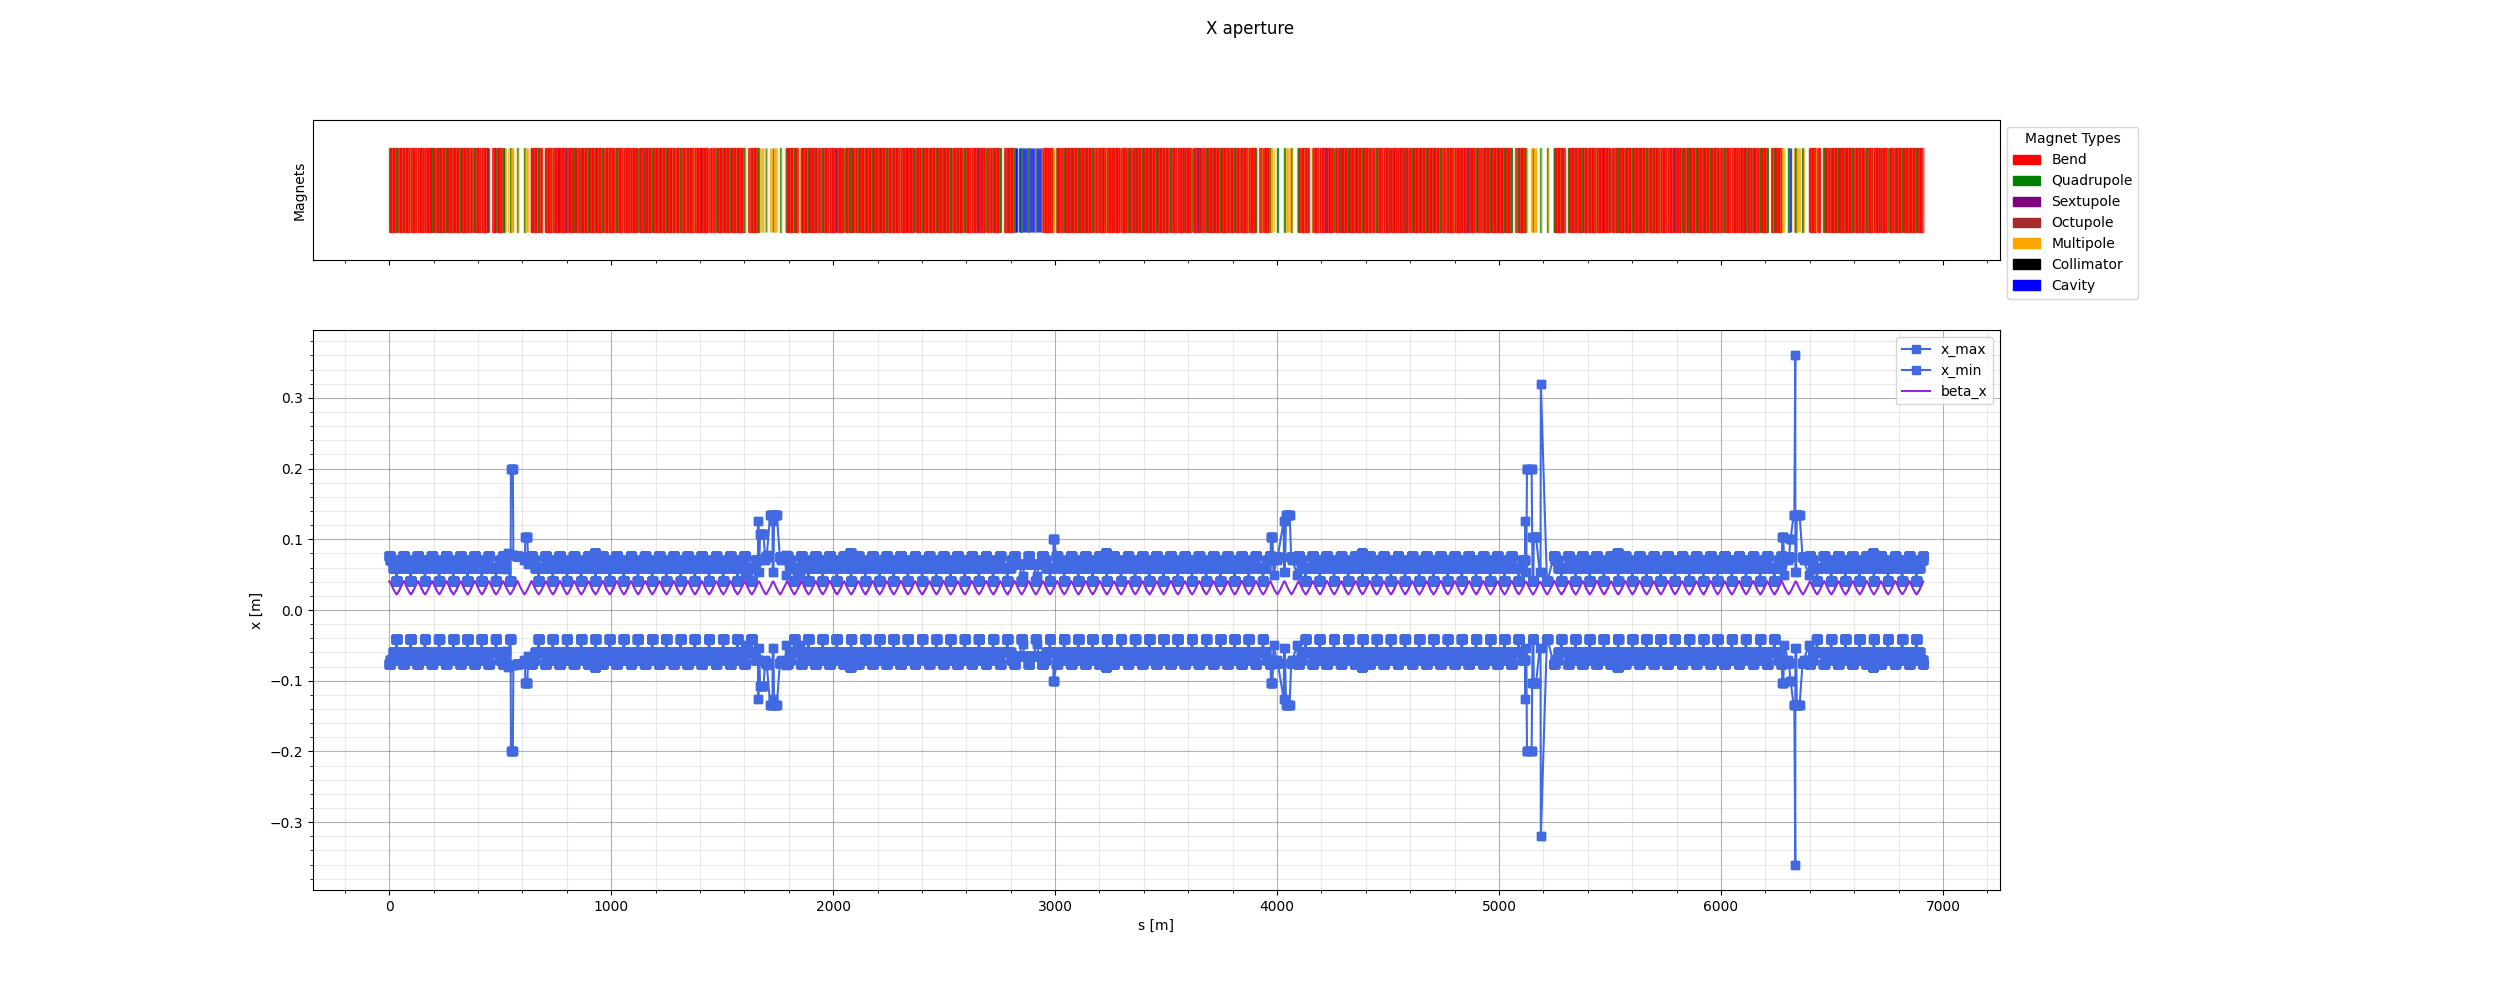

In [11]:
fig, (ax_magnet, ax_ap) = plt.subplots(2, 1, sharex=True, figsize=(25, 10), gridspec_kw={'height_ratios': [1, 4]})

#Plot aperture
ax_ap.plot(s_arr, x_max_arr, 's-', markersize=5.5, color='royalblue', label="x_max")
ax_ap.plot(s_arr, x_min_arr, 's-', markersize=5.5, color='royalblue', label="x_min")
ax_ap.plot(tw.s, 10*np.sqrt(tw.betx*exn*pmass/nrj), color='blueviolet', label='beta_x')

# Enable interactive mode
plt.minorticks_on()
plt.xlabel("s [m]")
plt.ylabel("x [m]")
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.grid(visible=True, which='major', color='#666666', linestyle='-', alpha=0.5)


#Plot thick elements
ax_magnet.set_ylim(0, 1)  # Define space for thick elements
ax_magnet.set_yticks([])  # Hide y-axis labels
ax_magnet.set_xticklabels([])  # Hide x labels to make it cleaner
ax_magnet.set_ylabel("Magnets")

for i in range(len(tab_thick.element_type[mask_thick])):
    name = tab_thick.name[mask_thick][i]
    s_start = tab_thick.s_start[mask_thick][i]
    s_end = tab_thick.s_end[mask_thick][i]
    element_type = tab_thick.element_type[mask_thick][i]
    color = thick_elements_colors[element_type]
    
    width = s_end - s_start
    rect = patches.Rectangle((s_start, 0.2), width, 0.6, edgecolor=color, facecolor=color, alpha=0.7, label=name)
    ax_magnet.add_patch(rect)

# Convert data coordinates to display (pixel) coordinates
def get_display_coords(x_data, y_data):
    return ax_ap.transData.transform(np.vstack([x_data, y_data]).T)

def on_click(event):
    if event.xdata is None or event.ydata is None:
        return  # Ignore clicks outside the plot area
    
    if event.inaxes == ax_magnet:
        click_x = event.xdata
        
        # Remove previous annotations
        for annotation in reversed(ax_magnet.texts):
            annotation.remove()
        
        # Find the closest magnet
        distances = np.abs(s_centers - click_x)
        min_index = np.argmin(distances)
        
        
        sensitivity = 0.5  # Adjust if needed
        
        
        if click_x >= s_starts[min_index]-sensitivity and click_x <= s_ends[min_index]+sensitivity:
            index = min_index
        
        elif min_index > 0 and click_x >= s_starts[min_index-1]-sensitivity and click_x <= s_ends[min_index-1]+sensitivity:
            index = min_index-1
        
        elif min_index < len(s_centers) - 1 and click_x >= s_starts[min_index+1]-sensitivity and click_x <= s_ends[min_index+1]+sensitivity:
            index = min_index+1
        
        else:
            return # Ignore clicks outside the magnet area
        
        # Annotate the clicked magnet
        ax_magnet.annotate(f"{magnet_names[index]}\ns = {s_centers[index]:.2f} m",
                        xy=(s_centers[index], 0.95),
                        xytext=(s_centers[index], 0.999),
                        ha="center", fontsize=10, color="black",
                        bbox=dict(facecolor="yellow", edgecolor="black", alpha=0.7),
                        arrowprops=dict(facecolor="black", arrowstyle="->"))
        
        fig.canvas.draw_idle()  # Update the figure
    
    if event.inaxes == ax_ap:
        # Convert clicked position to display coordinates
        click_x, click_y = event.x, event.y
        
        for annotation in reversed(ax_ap.texts):
            annotation.remove()
            
        # Convert data points to pixel coordinates
        display_coords_max = get_display_coords(s_arr, x_max_arr)
        display_coords_min = get_display_coords(s_arr, x_min_arr)

        # Stack all points together
        all_coords = np.vstack([display_coords_max, display_coords_min])
        indices = np.hstack([np.arange(len(s_arr)), np.arange(len(s_arr))])  # Keep track of which index it belongs to
        dataset_labels = np.hstack(["max"] * len(s_arr) + ["min"] * len(s_arr))  # Label the source (max or min)

        # Find closest point in pixel coordinates
        distances = np.sqrt((all_coords[:, 0] - click_x) ** 2 + (all_coords[:, 1] - click_y) ** 2)
        min_index = np.argmin(distances)
        
        # Define a sensitivity threshold (in pixels)
        sensitivity = 10  # Adjust if needed

        if distances[min_index] < sensitivity:
            # Remove previous annotations
            for annotation in reversed(ax_ap.texts):
                annotation.remove()

            # Get current zoom level
            x_range = ax_ap.get_xlim()
            y_range = ax_ap.get_ylim()
            
            # Calculate adaptive offsets based on zoom level
            x_offset = (x_range[1] - x_range[0]) * 0.02  # 2% of x-axis range
            y_offset = (y_range[1] - y_range[0]) * 0.02  # 2% of y-axis range

            # Determine whether it's from x_max or x_min
            original_index = indices[min_index]
            dataset = dataset_labels[min_index]
            y_value = x_max_arr[original_index] if dataset == "max" else x_min_arr[original_index]

            # Annotate the closest point
            ax_ap.annotate(f"{names_arr[original_index]} ({dataset})\n(s={s_arr[original_index]:.2f}, x={y_value:.2f})",
                        xy=(s_arr[original_index], y_value),
                        xytext=(s_arr[original_index] + x_offset, y_value + y_offset),
                        bbox=dict(facecolor='yellow', edgecolor='black', alpha=0.7),
                        arrowprops=dict(facecolor=color, arrowstyle="->"))
            fig.canvas.draw_idle()
            
def on_zoom(event):
    # Temporarily disable callback to prevent recursion
    ax_ap.callbacks.disconnect(on_zoom.cid)
    
    x_min, x_max = ax_ap.get_xlim()
    ax_magnet.set_xlim(x_min, x_max)
    
    update_xticks(event)
    # Reconnect callback
    on_zoom.cid = ax_ap.callbacks.connect('xlim_changed', on_zoom)

    fig.canvas.draw_idle()
    
def format_coord(x, y):
    return f"s = {x:.2f}, x = {y:.2f}"

def update_xticks(event):
    x_min, x_max = event.get_xlim()
    
    # Use MaxNLocator to find reasonable tick positions (e.g., multiples of 10, 50, etc.)
    locator = ticker.MaxNLocator(nbins=10, integer=True, prune="both")  # Adjust nbins if needed
    xticks = locator.tick_values(x_min, x_max)

    # Update ticks and labels
    ax_ap.set_xticks(xticks)
    ax_ap.set_xticklabels([f"{tick:.0f}" for tick in xticks]) 
    #ax_ap.figure.canvas.draw_idle()


# Connect click event to the figure
fig.canvas.mpl_connect('button_press_event', on_click)
on_zoom.cid = ax_ap.callbacks.connect('xlim_changed', on_zoom)
ax_ap.format_coord = format_coord
ax_magnet.format_coord = format_coord

# Create legend patches
legend_patches = [patches.Patch(color=color, label=element) for element, color in thick_elements_colors.items()]

# Add the legend outside the main plot
ax_magnet.legend(handles=legend_patches, loc="upper left", bbox_to_anchor=(1, 1), title="Magnet Types", fontsize=10)
fig.subplots_adjust(right=0.8)

xticks = np.linspace(0, 7000, num=8)
ax_ap.set_xticks(xticks)
ax_ap.set_xticklabels([f"{int(tick)}" for tick in xticks])

plt.suptitle('X aperture')
plt.legend()
plt.show()

In [12]:
import pickle

In [15]:
with open('final_res.pkl', 'rb') as f:
    final_res = pickle.load(f)

In [17]:
len(final_res['s'])

21604

In [18]:
len(final_res[32][349]['x'])

21604

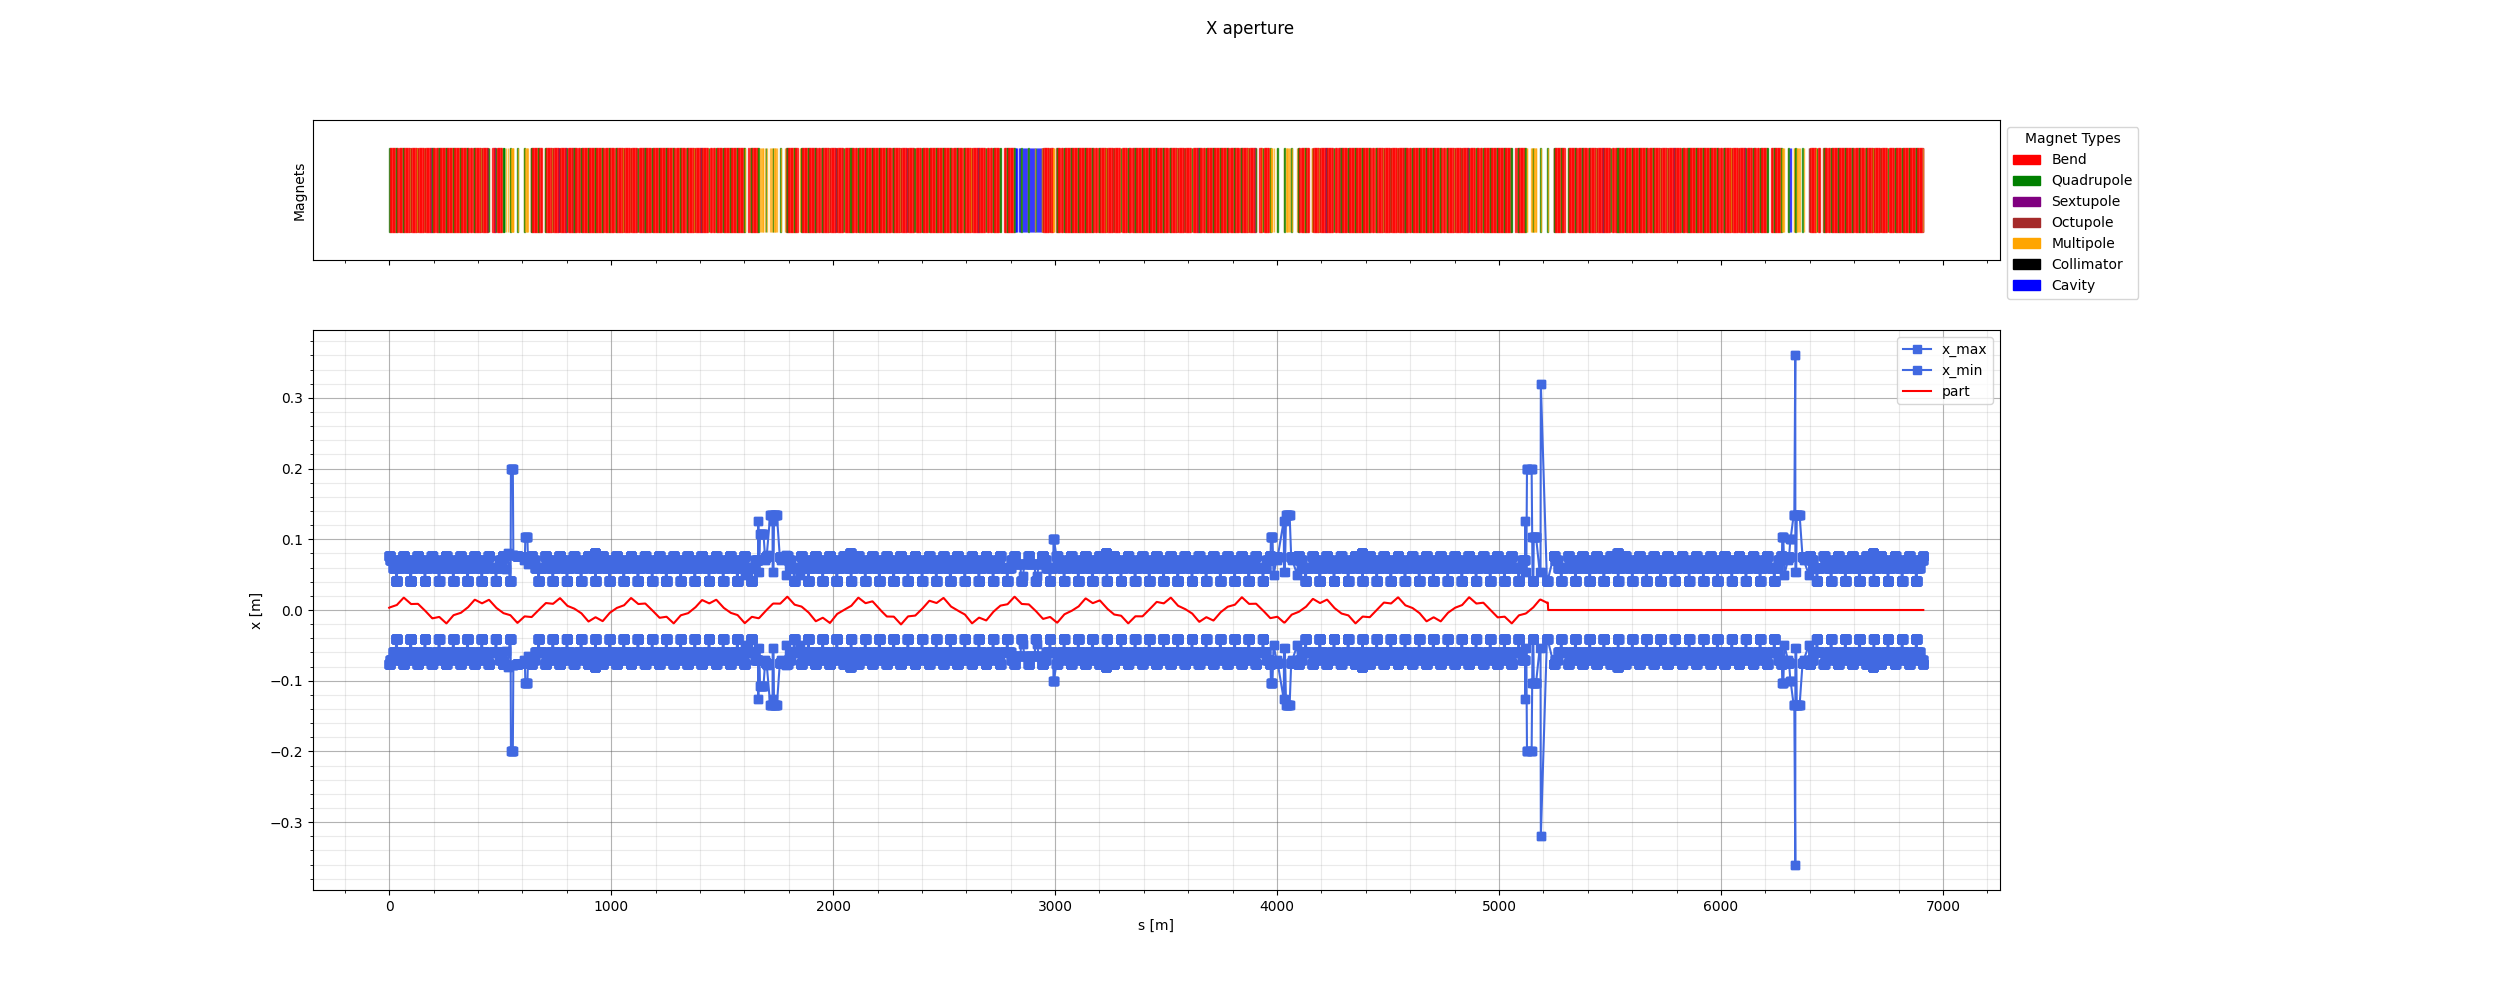

In [21]:
fig, (ax_magnet, ax_ap) = plt.subplots(2, 1, sharex=True, figsize=(25, 10), gridspec_kw={'height_ratios': [1, 4]})

#Plot aperture
ax_ap.plot(s_arr, x_max_arr, 's-', markersize=5.5, color='royalblue', label="x_max")
ax_ap.plot(s_arr, x_min_arr, 's-', markersize=5.5, color='royalblue', label="x_min")
#ax_ap.plot(tw.s, 10*np.sqrt(tw.betx*exn*pmass/nrj), color='blueviolet', label='beta_x')
ax_ap.plot(final_res['s'], final_res[32][349]['x'], '-', markersize=5.5, color='red', label="part")

# Enable interactive mode
plt.minorticks_on()
plt.xlabel("s [m]")
plt.ylabel("x [m]")
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.grid(visible=True, which='major', color='#666666', linestyle='-', alpha=0.5)


#Plot thick elements
ax_magnet.set_ylim(0, 1)  # Define space for thick elements
ax_magnet.set_yticks([])  # Hide y-axis labels
ax_magnet.set_xticklabels([])  # Hide x labels to make it cleaner
ax_magnet.set_ylabel("Magnets")

for i in range(len(tab_thick.element_type[mask_thick])):
    name = tab_thick.name[mask_thick][i]
    s_start = tab_thick.s_start[mask_thick][i]
    s_end = tab_thick.s_end[mask_thick][i]
    element_type = tab_thick.element_type[mask_thick][i]
    color = thick_elements_colors[element_type]
    
    width = s_end - s_start
    rect = patches.Rectangle((s_start, 0.2), width, 0.6, edgecolor=color, facecolor=color, alpha=0.7, label=name)
    ax_magnet.add_patch(rect)

# Convert data coordinates to display (pixel) coordinates
def get_display_coords(x_data, y_data):
    return ax_ap.transData.transform(np.vstack([x_data, y_data]).T)

def on_click(event):
    if event.xdata is None or event.ydata is None:
        return  # Ignore clicks outside the plot area
    
    if event.inaxes == ax_magnet:
        click_x = event.xdata
        
        # Remove previous annotations
        for annotation in reversed(ax_magnet.texts):
            annotation.remove()
        
        # Find the closest magnet
        distances = np.abs(s_centers - click_x)
        min_index = np.argmin(distances)
        
        
        sensitivity = 0.5  # Adjust if needed
        
        
        if click_x >= s_starts[min_index]-sensitivity and click_x <= s_ends[min_index]+sensitivity:
            index = min_index
        
        elif min_index > 0 and click_x >= s_starts[min_index-1]-sensitivity and click_x <= s_ends[min_index-1]+sensitivity:
            index = min_index-1
        
        elif min_index < len(s_centers) - 1 and click_x >= s_starts[min_index+1]-sensitivity and click_x <= s_ends[min_index+1]+sensitivity:
            index = min_index+1
        
        else:
            return # Ignore clicks outside the magnet area
        
        # Annotate the clicked magnet
        ax_magnet.annotate(f"{magnet_names[index]}\ns = {s_centers[index]:.2f} m",
                        xy=(s_centers[index], 0.95),
                        xytext=(s_centers[index], 0.999),
                        ha="center", fontsize=10, color="black",
                        bbox=dict(facecolor="yellow", edgecolor="black", alpha=0.7),
                        arrowprops=dict(facecolor="black", arrowstyle="->"))
        
        fig.canvas.draw_idle()  # Update the figure
    
    if event.inaxes == ax_ap:
        # Convert clicked position to display coordinates
        click_x, click_y = event.x, event.y
        
        for annotation in reversed(ax_ap.texts):
            annotation.remove()
            
        # Convert data points to pixel coordinates
        display_coords_max = get_display_coords(s_arr, x_max_arr)
        display_coords_min = get_display_coords(s_arr, x_min_arr)

        # Stack all points together
        all_coords = np.vstack([display_coords_max, display_coords_min])
        indices = np.hstack([np.arange(len(s_arr)), np.arange(len(s_arr))])  # Keep track of which index it belongs to
        dataset_labels = np.hstack(["max"] * len(s_arr) + ["min"] * len(s_arr))  # Label the source (max or min)

        # Find closest point in pixel coordinates
        distances = np.sqrt((all_coords[:, 0] - click_x) ** 2 + (all_coords[:, 1] - click_y) ** 2)
        min_index = np.argmin(distances)
        
        # Define a sensitivity threshold (in pixels)
        sensitivity = 10  # Adjust if needed

        if distances[min_index] < sensitivity:
            # Remove previous annotations
            for annotation in reversed(ax_ap.texts):
                annotation.remove()

            # Get current zoom level
            x_range = ax_ap.get_xlim()
            y_range = ax_ap.get_ylim()
            
            # Calculate adaptive offsets based on zoom level
            x_offset = (x_range[1] - x_range[0]) * 0.02  # 2% of x-axis range
            y_offset = (y_range[1] - y_range[0]) * 0.02  # 2% of y-axis range

            # Determine whether it's from x_max or x_min
            original_index = indices[min_index]
            dataset = dataset_labels[min_index]
            y_value = x_max_arr[original_index] if dataset == "max" else x_min_arr[original_index]

            # Annotate the closest point
            ax_ap.annotate(f"{names_arr[original_index]} ({dataset})\n(s={s_arr[original_index]:.2f}, x={y_value:.2f})",
                        xy=(s_arr[original_index], y_value),
                        xytext=(s_arr[original_index] + x_offset, y_value + y_offset),
                        bbox=dict(facecolor='yellow', edgecolor='black', alpha=0.7),
                        arrowprops=dict(facecolor=color, arrowstyle="->"))
            fig.canvas.draw_idle()
            
def on_zoom(event):
    # Temporarily disable callback to prevent recursion
    ax_ap.callbacks.disconnect(on_zoom.cid)
    
    x_min, x_max = ax_ap.get_xlim()
    ax_magnet.set_xlim(x_min, x_max)
    
    update_xticks(event)
    # Reconnect callback
    on_zoom.cid = ax_ap.callbacks.connect('xlim_changed', on_zoom)

    fig.canvas.draw_idle()
    
def format_coord(x, y):
    return f"s = {x:.2f}, x = {y:.2f}"

def update_xticks(event):
    x_min, x_max = event.get_xlim()
    
    # Use MaxNLocator to find reasonable tick positions (e.g., multiples of 10, 50, etc.)
    locator = ticker.MaxNLocator(nbins=10, integer=True, prune="both")  # Adjust nbins if needed
    xticks = locator.tick_values(x_min, x_max)

    # Update ticks and labels
    ax_ap.set_xticks(xticks)
    ax_ap.set_xticklabels([f"{tick:.0f}" for tick in xticks]) 
    #ax_ap.figure.canvas.draw_idle()


# Connect click event to the figure
fig.canvas.mpl_connect('button_press_event', on_click)
on_zoom.cid = ax_ap.callbacks.connect('xlim_changed', on_zoom)
ax_ap.format_coord = format_coord
ax_magnet.format_coord = format_coord

# Create legend patches
legend_patches = [patches.Patch(color=color, label=element) for element, color in thick_elements_colors.items()]

# Add the legend outside the main plot
ax_magnet.legend(handles=legend_patches, loc="upper left", bbox_to_anchor=(1, 1), title="Magnet Types", fontsize=10)
fig.subplots_adjust(right=0.8)

xticks = np.linspace(0, 7000, num=8)
ax_ap.set_xticks(xticks)
ax_ap.set_xticklabels([f"{int(tick)}" for tick in xticks])

plt.suptitle('X aperture')
plt.legend()
plt.show()

# Beam in sigma size

In [10]:
sigma = np.sqrt(tw.betx*exn/tw.gamma0)

In [11]:
sigma_restr = np.array([sigma[i] for i in range(len(sigma)) if mask[i]])

In [20]:
x_max_arr/sigma_restr

array([21.0090004 , 21.0090004 , 20.94459616, ..., 21.30777722,
       21.20649114, 21.20649114])

In [19]:
np.unique(x_max_arr)

array([0.0415 , 0.048  , 0.05   , 0.05378, 0.0575 , 0.0597 , 0.065  ,
       0.0661 , 0.071  , 0.0712 , 0.0755 , 0.076  , 0.0775 , 0.078  ,
       0.08   , 0.08102, 0.1    , 0.103  , 0.10755, 0.1265 , 0.1339 ,
       0.2    , 0.32   , 0.36   ])

In [21]:
x_max_arr = x_max_arr/sigma_restr
x_min_arr = x_min_arr/sigma_restr

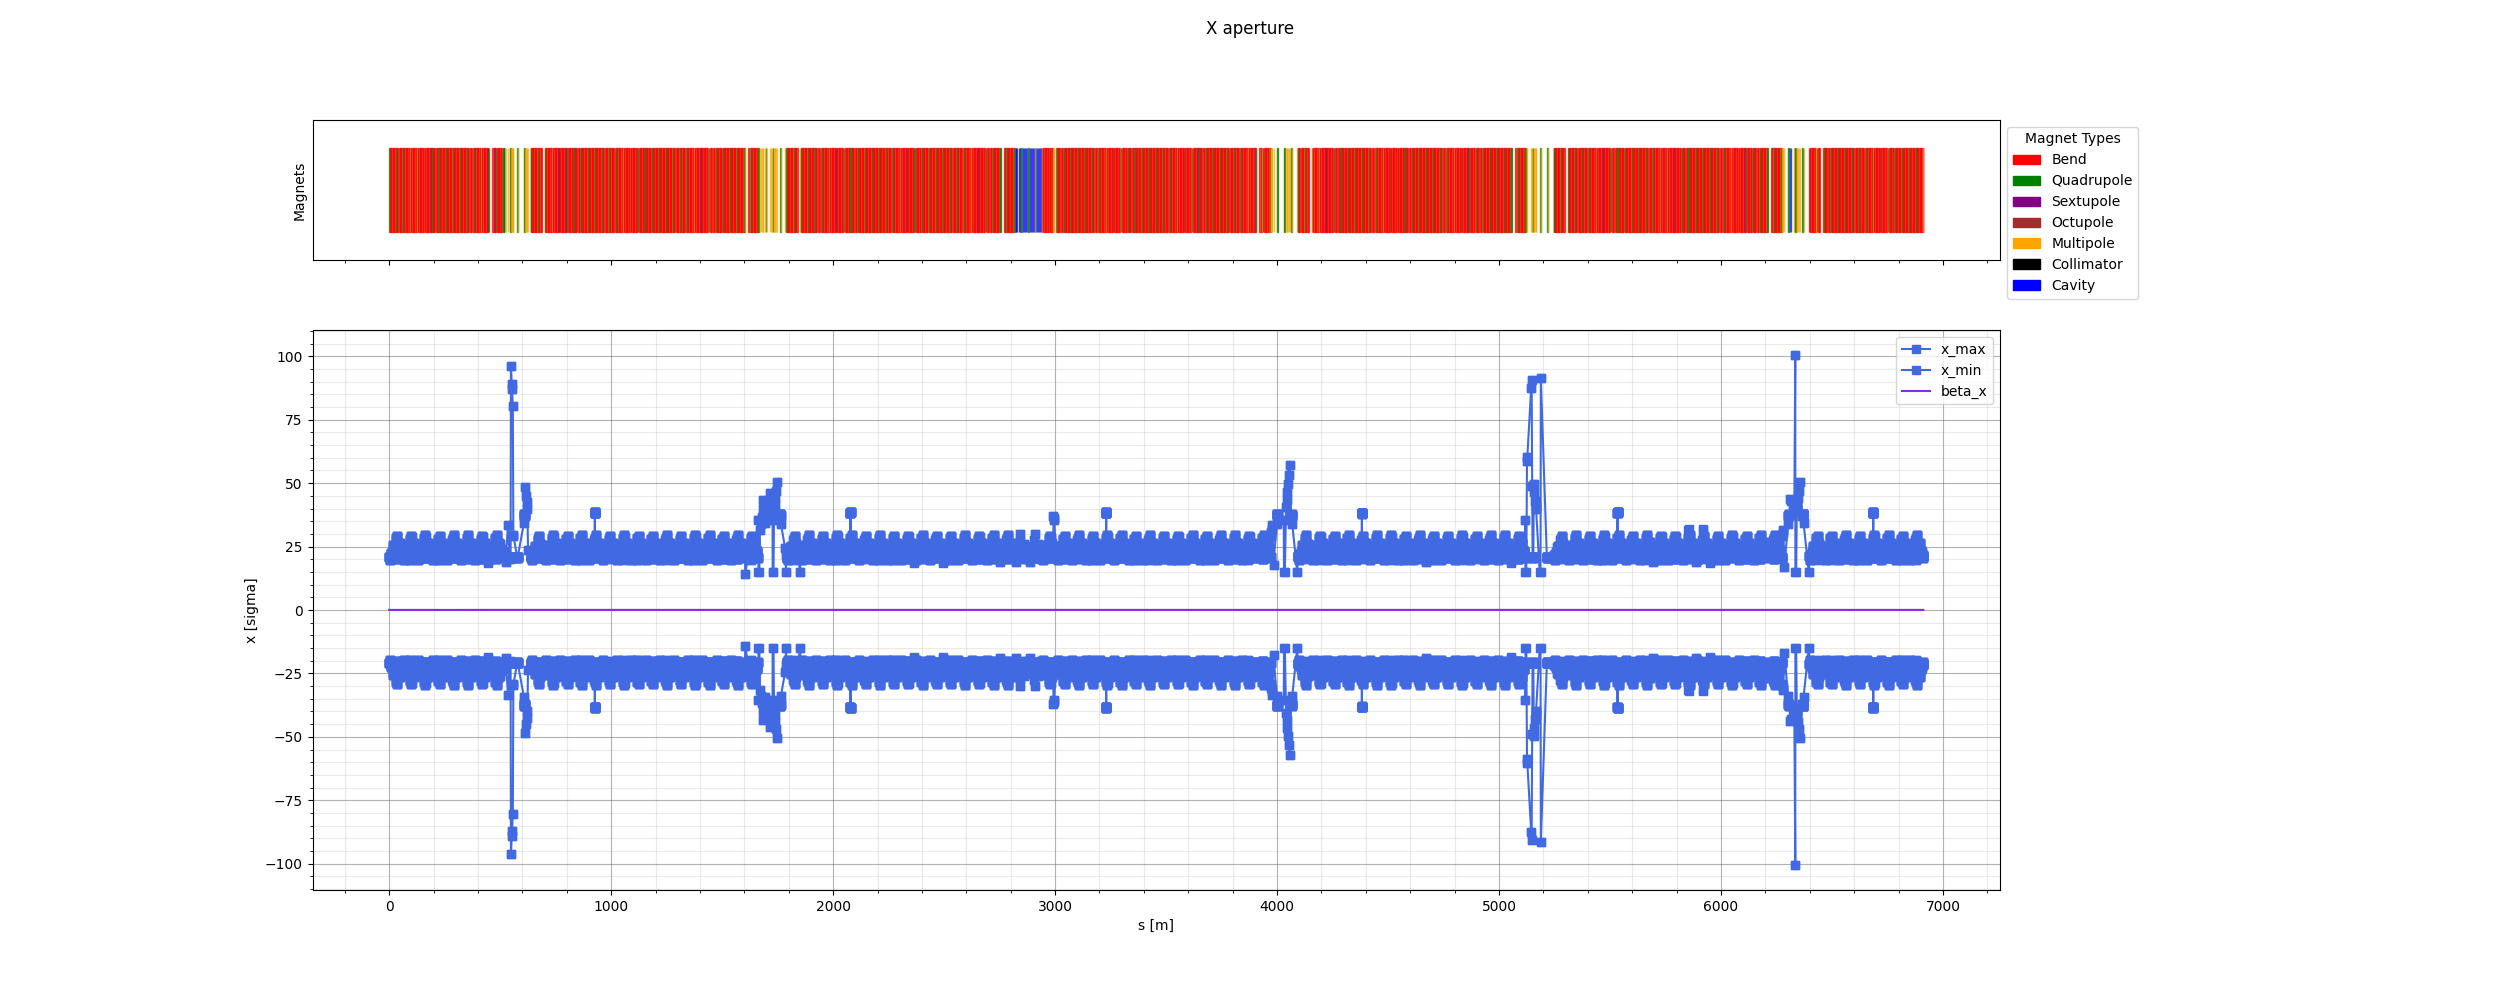

20.239718134999674
8.448621830545841
96.3473767443556
3.616515287147395
20.518895249053802
0.28960745914037045
20.131830071162266
3.82862851101925
33.36724261349974
43.41451745107403
1.6930384561176233
96.3473767443556
2.2261304224483625
87.13183011942671
22.42327830188061
4.2162863925504395
96.3473767443556
2.3826282588868226
20.586989263571827
3.1303067769005297
37.49889270249502
146.45513549676903
12.641586013235207
44.821208485648135
26.511279052056977
85.14173550085567
7.609281690262774
-26.43588206188545
2.8084939581132855
20.904124105974745
1.515322780962606
20.122776586182706
153.84104423518264
12.739217314023255
1.995416906995908
21.751127571940366
61.75122931016202
46.23945975494907
46.99378800907044
66.57423729046752
40.2026980158812
49.81142620419307
53.419293454532415
45.66799572891608
53.20443773260532
53.204437732605385
53.204437732605385
13.833261369510025
1.232571336557271
20.77133243006965
16.128038046119805
60.556476852940634
39.811563685149935
3.269689375948553
14.9

In [ ]:
fig, (ax_magnet, ax_ap) = plt.subplots(2, 1, sharex=True, figsize=(25, 10), gridspec_kw={'height_ratios': [1, 4]})

#Plot aperture
ax_ap.plot(s_arr, x_max_arr, 's-', markersize=5.5, color='royalblue', label="x_max")
ax_ap.plot(s_arr, x_min_arr, 's-', markersize=5.5, color='royalblue', label="x_min")
ax_ap.plot(tw.s, 10*np.sqrt(tw.betx*exn*pmass/nrj), color='blueviolet', label='beta_x')

# Enable interactive mode
plt.minorticks_on()
plt.xlabel("s [m]")
plt.ylabel("x [sigma]")
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.grid(visible=True, which='major', color='#666666', linestyle='-', alpha=0.5)


#Plot thick elements
ax_magnet.set_ylim(0, 1)  # Define space for thick elements
ax_magnet.set_yticks([])  # Hide y-axis labels
ax_magnet.set_xticklabels([])  # Hide x labels to make it cleaner
ax_magnet.set_ylabel("Magnets")

for i in range(len(tab_thick.element_type[mask_thick])):
    name = tab_thick.name[mask_thick][i]
    s_start = tab_thick.s_start[mask_thick][i]
    s_end = tab_thick.s_end[mask_thick][i]
    element_type = tab_thick.element_type[mask_thick][i]
    color = thick_elements_colors[element_type]
    
    width = s_end - s_start
    rect = patches.Rectangle((s_start, 0.2), width, 0.6, edgecolor=color, facecolor=color, alpha=0.7, label=name)
    ax_magnet.add_patch(rect)

# Convert data coordinates to display (pixel) coordinates
def get_display_coords(x_data, y_data):
    return ax_ap.transData.transform(np.vstack([x_data, y_data]).T)

def on_click(event):
    if event.xdata is None or event.ydata is None:
        return  # Ignore clicks outside the plot area
    
    if event.inaxes == ax_magnet:
        click_x = event.xdata
        
        # Remove previous annotations
        for annotation in reversed(ax_magnet.texts):
            annotation.remove()
        
        # Find the closest magnet
        distances = np.abs(s_centers - click_x)
        min_index = np.argmin(distances)
        
        
        sensitivity = 0.5  # Adjust if needed
        
        
        if click_x >= s_starts[min_index]-sensitivity and click_x <= s_ends[min_index]+sensitivity:
            index = min_index
        
        elif min_index > 0 and click_x >= s_starts[min_index-1]-sensitivity and click_x <= s_ends[min_index-1]+sensitivity:
            index = min_index-1
        
        elif min_index < len(s_centers) - 1 and click_x >= s_starts[min_index+1]-sensitivity and click_x <= s_ends[min_index+1]+sensitivity:
            index = min_index+1
        
        else:
            return # Ignore clicks outside the magnet area
        
        # Annotate the clicked magnet
        ax_magnet.annotate(f"{magnet_names[index]}\ns = {s_centers[index]:.2f} m",
                        xy=(s_centers[index], 0.95),
                        xytext=(s_centers[index], 0.999),
                        ha="center", fontsize=10, color="black",
                        bbox=dict(facecolor="yellow", edgecolor="black", alpha=0.7),
                        arrowprops=dict(facecolor="black", arrowstyle="->"))
        
        fig.canvas.draw_idle()  # Update the figure
    
    if event.inaxes == ax_ap:
        # Convert clicked position to display coordinates
        click_x, click_y = event.x, event.y
        
        for annotation in reversed(ax_ap.texts):
            annotation.remove()
            
        # Convert data points to pixel coordinates
        display_coords_max = get_display_coords(s_arr, x_max_arr)
        display_coords_min = get_display_coords(s_arr, x_min_arr)

        # Stack all points together
        all_coords = np.vstack([display_coords_max, display_coords_min])
        indices = np.hstack([np.arange(len(s_arr)), np.arange(len(s_arr))])  # Keep track of which index it belongs to
        dataset_labels = np.hstack(["max"] * len(s_arr) + ["min"] * len(s_arr))  # Label the source (max or min)

        # Find closest point in pixel coordinates
        distances = np.sqrt((all_coords[:, 0] - click_x) ** 2 + (all_coords[:, 1] - click_y) ** 2)
        min_index = np.argmin(distances)
        
        # Define a sensitivity threshold (in pixels)
        sensitivity = 10 # Adjust if needed
        print(distances[min_index])
        if distances[min_index] < sensitivity:
            # Remove previous annotations
            for annotation in reversed(ax_ap.texts):
                annotation.remove()

            # Get current zoom level
            x_range = ax_ap.get_xlim()
            y_range = ax_ap.get_ylim()
            
            # Calculate adaptive offsets based on zoom level
            x_offset = (x_range[1] - x_range[0]) * 0.02  # 2% of x-axis range
            y_offset = (y_range[1] - y_range[0]) * 0.02  # 2% of y-axis range

            # Determine whether it's from x_max or x_min
            original_index = indices[min_index]
            dataset = dataset_labels[min_index]
            y_value = x_max_arr[original_index] if dataset == "max" else x_min_arr[original_index]
            print(y_value)

            # Annotate the closest point
            ax_ap.annotate(f"{names_arr[original_index]} ({dataset})\n(s={s_arr[original_index]:.2f}, x={y_value:.2f})",
                        xy=(s_arr[original_index], y_value),
                        xytext=(s_arr[original_index] + x_offset, y_value + y_offset),
                        bbox=dict(facecolor='yellow', edgecolor='black', alpha=0.7),
                        arrowprops=dict(facecolor=color, arrowstyle="->"))
            fig.canvas.draw_idle()
            
def on_zoom(event):
    # Temporarily disable callback to prevent recursion
    ax_ap.callbacks.disconnect(on_zoom.cid)
    
    x_min, x_max = ax_ap.get_xlim()
    ax_magnet.set_xlim(x_min, x_max)
    
    update_xticks(event)
    # Reconnect callback
    on_zoom.cid = ax_ap.callbacks.connect('xlim_changed', on_zoom)

    fig.canvas.draw_idle()
    
def format_coord(x, y):
    return f"s = {x:.2f}, x = {y:.2f}"

def update_xticks(event):
    x_min, x_max = event.get_xlim()
    
    # Use MaxNLocator to find reasonable tick positions (e.g., multiples of 10, 50, etc.)
    locator = ticker.MaxNLocator(nbins=10, integer=True, prune="both")  # Adjust nbins if needed
    xticks = locator.tick_values(x_min, x_max)

    # Update ticks and labels
    ax_ap.set_xticks(xticks)
    ax_ap.set_xticklabels([f"{tick:.0f}" for tick in xticks]) 
    #ax_ap.figure.canvas.draw_idle()


# Connect click event to the figure
fig.canvas.mpl_connect('button_press_event', on_click)
on_zoom.cid = ax_ap.callbacks.connect('xlim_changed', on_zoom)
ax_ap.format_coord = format_coord
ax_magnet.format_coord = format_coord

# Create legend patches
legend_patches = [patches.Patch(color=color, label=element) for element, color in thick_elements_colors.items()]

# Add the legend outside the main plot
ax_magnet.legend(handles=legend_patches, loc="upper left", bbox_to_anchor=(1, 1), title="Magnet Types", fontsize=10)
fig.subplots_adjust(right=0.8)

xticks = np.linspace(0, 7000, num=8)
ax_ap.set_xticks(xticks)
ax_ap.set_xticklabels([f"{int(tick)}" for tick in xticks])

plt.suptitle('X aperture')
plt.legend()
plt.show()

In [14]:
x_max_arr/sigma_restr

array([5807.60654967, 5807.60654967, 5772.05405622, ..., 5973.96539281,
       5917.30613809, 5917.30613809])

In [52]:
np.where(x_max_arr/sigma_restr==np.max(x_max_arr/sigma_restr))

(array([13860, 13861]),)

In [49]:
np.max(sigma_restr)

np.float64(0.0036915599243004483)

# Plotter x and y

In [44]:
def get_display_coords(ax_ap, x_data, y_data):
    return ax_ap.transData.transform(np.vstack([x_data, y_data]).T)

def format_coord(x, y):
        return f"s = {x:.2f}, x = {y:.2f}"

In [45]:
def update_aper_names(event, ax_ap, ap_max, ap_min, names_arr, s_arr):
    click_x, click_y = event.x, event.y
    
    for annotation in reversed(ax_ap.texts):
        annotation.remove()
        
    # Convert data points to pixel coordinates
    display_coords_max = get_display_coords(ax_ap, s_arr, ap_max)
    display_coords_min = get_display_coords(ax_ap, s_arr, ap_min)

    # Stack all points together
    all_coords = np.vstack([display_coords_max, display_coords_min])
    indices = np.hstack([np.arange(len(s_arr)), np.arange(len(s_arr))])  # Keep track of which index it belongs to
    dataset_labels = np.hstack(["max"] * len(s_arr) + ["min"] * len(s_arr))  # Label the source (max or min)

    # Find closest point in pixel coordinates
    distances = np.sqrt((all_coords[:, 0] - click_x) ** 2 + (all_coords[:, 1] - click_y) ** 2)
    min_index = np.argmin(distances)
    
    # Define a sensitivity threshold (in pixels)
    sensitivity = 10  # Adjust if needed

    if distances[min_index] < sensitivity:
        # Remove previous annotations
        for annotation in reversed(ax_ap.texts):
            annotation.remove()

        # Get current zoom level
        x_range = ax_ap.get_xlim()
        y_range = ax_ap.get_ylim()
        
        # Calculate adaptive offsets based on zoom level
        x_offset = (x_range[1] - x_range[0]) * 0.02  # 2% of x-axis range
        y_offset = (y_range[1] - y_range[0]) * 0.02  # 2% of y-axis range

        # Determine whether it's from x_max or x_min
        original_index = indices[min_index]
        dataset = dataset_labels[min_index]
        y_value = x_max_arr[original_index] if dataset == "max" else x_min_arr[original_index]

        # Annotate the closest point
        ax_ap.annotate(f"{names_arr[original_index]} ({dataset})\n(s={s_arr[original_index]:.2f}, x={y_value:.2f})",
                    xy=(s_arr[original_index], y_value),
                    xytext=(s_arr[original_index] + x_offset, y_value + y_offset),
                    bbox=dict(facecolor='yellow', edgecolor='black', alpha=0.7),
                    arrowprops=dict(facecolor=color, arrowstyle="->"))
        fig.canvas.draw_idle()

In [51]:
def plot_interactive_apertures(line):
    #Computing apertures
    tab = line.get_table()
    mask = [el.startswith('Limit') for el in tab.element_type]

    x_max_arr = np.array([get_x_extent(line[name])[1] for name in tab.name[mask]])
    x_min_arr = np.array([get_x_extent(line[name])[0] for name in tab.name[mask]])

    y_max_arr = np.array([get_y_extent(line[name])[1] for name in tab.name[mask]])
    y_min_arr = np.array([get_y_extent(line[name])[0] for name in tab.name[mask]])

    names_arr = np.array(tab.name[mask])
    s_arr = np.array(tab.s[mask])
    
    fig, (ax_magnet, ax_ap_x, ax_ap_y) = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [1, 4, 4]})
    
    for ax_ap in [ax_ap_x, ax_ap_y]:
        if ax_ap==ax_ap_x:
            label_ax = 'x'
            ap_max = x_max_arr
            ap_min = x_min_arr
            
        elif ax_ap==ax_ap_y:
            label_ax = 'y'
            ap_max = y_max_arr
            ap_min = y_min_arr
            
        ax_ap.plot(s_arr, ap_max, 's-', markersize=5.5, color='royalblue', label = f"{label_ax}_max")
        ax_ap.plot(s_arr, ap_min, 's-', markersize=5.5, color='royalblue', label = f"{label_ax}_min")
        
        ax_ap.minorticks_on()
        ax_ap.set_xlabel("s [m]")
        ax_ap.set_ylabel(f"{label_ax} [m]")
        ax_ap.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        ax_ap.grid(visible=True, which='major', color='#666666', linestyle='-', alpha=0.5)
        ax_ap.legend()
    
    #Plot thick elements
    ax_magnet.set_ylim(0, 1)  # Define space for thick elements
    ax_magnet.set_yticks([])  # Hide y-axis labels
    ax_magnet.set_xticklabels([])  # Hide x labels to make it cleaner
    ax_magnet.set_ylabel("Magnets")

    for i in range(len(tab_thick.element_type[mask_thick])):
        name = tab_thick.name[mask_thick][i]
        s_start = tab_thick.s_start[mask_thick][i]
        s_end = tab_thick.s_end[mask_thick][i]
        element_type = tab_thick.element_type[mask_thick][i]
        color = thick_elements_colors[element_type]
        
        width = s_end - s_start
        rect = patches.Rectangle((s_start, 0.2), width, 0.6, edgecolor=color, facecolor=color, alpha=0.7, label=name)
        ax_magnet.add_patch(rect)
        
    #On click function
    def on_click(event):
        if event.xdata is None or event.ydata is None:
            return  # Ignore clicks outside the plot area
        
        if event.inaxes == ax_magnet:
            click_x = event.xdata
            
            # Remove previous annotations
            for annotation in reversed(ax_magnet.texts):
                annotation.remove()
            
            # Find the closest magnet
            distances = np.abs(s_centers - click_x)
            min_index = np.argmin(distances)
            
            
            sensitivity = 0.5  # Adjust if needed
            
            
            if click_x >= s_starts[min_index]-sensitivity and click_x <= s_ends[min_index]+sensitivity:
                index = min_index
            
            elif min_index > 0 and click_x >= s_starts[min_index-1]-sensitivity and click_x <= s_ends[min_index-1]+sensitivity:
                index = min_index-1
            
            elif min_index < len(s_centers) - 1 and click_x >= s_starts[min_index+1]-sensitivity and click_x <= s_ends[min_index+1]+sensitivity:
                index = min_index+1
            
            else:
                return # Ignore clicks outside the magnet area
            
            # Annotate the clicked magnet
            ax_magnet.annotate(f"{magnet_names[index]}\ns = {s_centers[index]:.2f} m",
                            xy=(s_centers[index], 0.95),
                            xytext=(s_centers[index], 0.999),
                            ha="center", fontsize=10, color="black",
                            bbox=dict(facecolor="yellow", edgecolor="black", alpha=0.7),
                            arrowprops=dict(facecolor="black", arrowstyle="->"))
            
            fig.canvas.draw_idle()  # Update the figure
        
        if event.inaxes == ax_ap_x or event.inaxes == ax_ap_y:
            if event.inaxes == ax_ap_x:
                update_aper_names(event, ax_ap_x, x_max_arr, x_min_arr, names_arr, s_arr)
            elif event.inaxes == ax_ap_y:
                update_aper_names(event, ax_ap_y, y_max_arr, y_min_arr, names_arr, s_arr)
                
    def on_zoom(event):
        # Temporarily disable callback to prevent recursion
        ax_ap_x.callbacks.disconnect(on_zoom.cid)
        ax_ap_y.callbacks.disconnect(on_zoom.cid)
        
        x_min, x_max = event.get_xlim()
        ax_magnet.set_xlim(x_min, x_max)
        
        update_xticks(event)
        # Reconnect callback
        on_zoom.cid = ax_ap_x.callbacks.connect('xlim_changed', on_zoom)
        on_zoom.cid = ax_ap_y.callbacks.connect('xlim_changed', on_zoom)

        fig.canvas.draw_idle()

    def update_xticks(event):
        x_min, x_max = event.get_xlim()
        
        # Use MaxNLocator to find reasonable tick positions (e.g., multiples of 10, 50, etc.)
        locator = ticker.MaxNLocator(nbins=10, integer=True, prune="both")  # Adjust nbins if needed
        xticks = locator.tick_values(x_min, x_max)

        # Update ticks and labels
        for ax_ap in [ax_ap_x, ax_ap_y]:
            ax_ap.set_xticks(xticks)
            ax_ap.set_xticklabels([f"{tick:.0f}" for tick in xticks])


    # Connect click event to the figure
    fig.canvas.mpl_connect('button_press_event', on_click)
    on_zoom.cid = ax_ap_x.callbacks.connect('xlim_changed', on_zoom)
    on_zoom.cid = ax_ap_y.callbacks.connect('xlim_changed', on_zoom)
    for ap in [ax_ap_x, ax_ap_y, ax_magnet]:
        ap.format_coord = format_coord

    # Create legend patches
    legend_patches = [patches.Patch(color=color, label=element) for element, color in thick_elements_colors.items()]

    # Add the legend outside the main plot
    ax_magnet.legend(handles=legend_patches, loc="upper left", bbox_to_anchor=(1, 1), title="Magnet Types", fontsize=10)
    fig.subplots_adjust(right=0.8)

    xticks = np.linspace(0, 7000, num=8)
    for ax_ap in [ax_ap_x, ax_ap_y]:
        ax_ap.set_xticks(xticks)
        ax_ap.set_xticklabels([f"{int(tick)}" for tick in xticks])
    
    plt.legend()
    
    return fig, (ax_magnet, ax_ap_x, ax_ap_y)


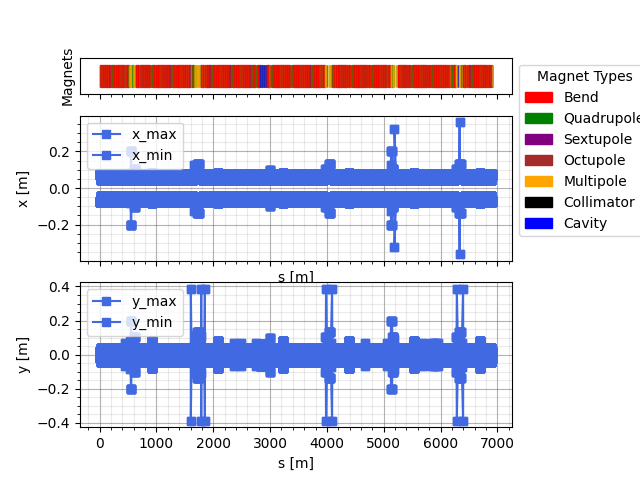

In [52]:
fig, (ax_magnet, ax_ap_x, ax_ap_y) = plot_interactive_apertures(line)

# Plotter dev and try-outs

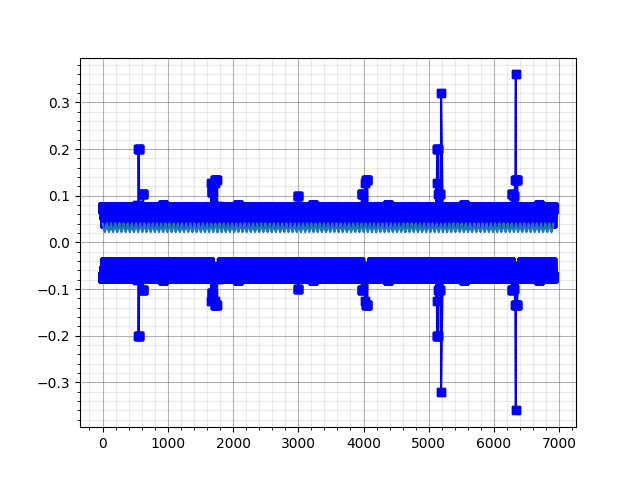

In [7]:
fig, ax = plt.subplots()

ax.plot(s_arr, x_max_arr, 's-', markersize = 5.5,color='blue')
ax.plot(s_arr, x_min_arr, 's-', markersize = 5.5,color='blue')

ax.plot(tw.s, 10*np.sqrt(tw.betx*exn*pmass/nrj))

#plt.xlim([1600,1700])
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.grid(visible=True, which='major', color='#666666', linestyle='-', alpha=0.5)
plt.show()

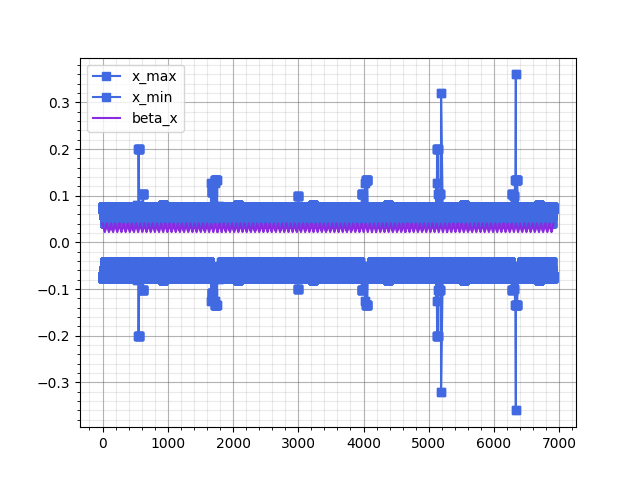

In [54]:
# Create the figure
fig, ax = plt.subplots()

# Scatter-like plots with lines
ax.plot(s_arr, x_max_arr, 's-', markersize=5.5, color='royalblue', label="x_max")
ax.plot(s_arr, x_min_arr, 's-', markersize=5.5, color='royalblue', label="x_min")
ax.plot(tw.s, 10*np.sqrt(tw.betx*exn*pmass/nrj), color='blueviolet', label='beta_x')

# Enable interactive mode
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.grid(visible=True, which='major', color='#666666', linestyle='-', alpha=0.5)

# Convert data coordinates to display (pixel) coordinates
def get_display_coords(x_data, y_data):
    return ax.transData.transform(np.vstack([x_data, y_data]).T)

# Click event function
def on_click(event):
    if event.xdata is None or event.ydata is None:
        return  # Ignore clicks outside the plot area

    # Convert clicked position to display coordinates
    click_x, click_y = event.x, event.y

    # Convert data points to pixel coordinates
    display_coords_max = get_display_coords(s_arr, x_max_arr)
    display_coords_min = get_display_coords(s_arr, x_min_arr)

    # Stack all points together
    all_coords = np.vstack([display_coords_max, display_coords_min])
    indices = np.hstack([np.arange(len(s_arr)), np.arange(len(s_arr))])  # Keep track of which index it belongs to
    dataset_labels = np.hstack(["max"] * len(s_arr) + ["min"] * len(s_arr))  # Label the source (max or min)

    # Find closest point in pixel coordinates
    distances = np.sqrt((all_coords[:, 0] - click_x) ** 2 + (all_coords[:, 1] - click_y) ** 2)
    min_index = np.argmin(distances)
    
    # Define a sensitivity threshold (in pixels)
    sensitivity = 10  # Adjust if needed

    if distances[min_index] < sensitivity:
        # Remove previous annotations
        for annotation in reversed(ax.texts):
            annotation.remove()

        # Get current zoom level
        x_range = ax.get_xlim()
        y_range = ax.get_ylim()
        
        # Calculate adaptive offsets based on zoom level
        x_offset = (x_range[1] - x_range[0]) * 0.02  # 2% of x-axis range
        y_offset = (y_range[1] - y_range[0]) * 0.02  # 2% of y-axis range

        # Determine whether it's from x_max or x_min
        original_index = indices[min_index]
        dataset = dataset_labels[min_index]
        y_value = x_max_arr[original_index] if dataset == "max" else x_min_arr[original_index]
        color = "blue" if dataset == "max" else "red"

        # Annotate the closest point
        ax.annotate(f"{names_arr[original_index]} ({dataset})\n(x={s_arr[original_index]:.2f}, y={y_value:.2f})",
                    xy=(s_arr[original_index], y_value),
                    xytext=(s_arr[original_index] + x_offset, y_value + y_offset),
                    bbox=dict(facecolor='yellow', edgecolor='black', alpha=0.7),
                    arrowprops=dict(facecolor=color, arrowstyle="->"))
        fig.canvas.draw_idle()

# Connect click event to the figure
fig.canvas.mpl_connect('button_press_event', on_click)

plt.legend()
plt.show()

In [16]:
line_thick = xt.Line.from_json('injection_thick_approx_ap.json')

Loading line from dict:   0%|          | 0/7477 [00:00<?, ?it/s]

Done loading line from dict.           


In [18]:
np.unique(line_thick.get_table().element_type)

array(['', 'Bend', 'Cavity', 'Drift', 'LimitEllipse', 'LimitRect',
       'Marker', 'Multipole', 'Octupole', 'Quadrupole', 'Sextupole'],
      dtype=object)

In [19]:
tab_thick = line_thick.get_table()

In [40]:
thick_elements_colors = {'Bend' :'red',
                        'Quadrupole' :'green',
                        'Sextupole' :'purple',
                        'Octupole' :'brown',
                        'Multipole' :'orange',
                        'Collimator' :'black',
                        'Cavity' :'blue'}
mask_thick = [el in thick_elements_colors for el in tab_thick.element_type]

In [35]:
tab_thick.cols

ColView: name s element_type isthick isreplica parent_name iscollective s_start s_center s_end env_name

In [37]:
tab_thick_restr = tab_thick.cols['name', 's_start', 's_end', 'element_type']

In [57]:
tab_thick_restr

Table: 7478 rows, 4 cols
name                            s_start         s_end element_type
sps$start                             0             0 Marker      
begi.10010                            0             0 Marker      
qf.10010_aper_upstream                0             0 LimitEllipse
qf.10010                              0         3.085 Quadrupole  
qf.10010_aper_downstream          3.085         3.085 LimitEllipse
drift_0                           3.085       3.44499 Drift       
mba.10030_aper_upstream         3.44499       3.44499 LimitRect   
mba.10030                       3.44499       9.70501 Bend        
mba.10030_aper_downstream       9.70501       9.70501 LimitRect   
drift_1                         9.70501        10.105 Drift       
...
mdh.63607_aper_upstream         6910.98       6910.98 LimitRect   
mdh.63607                       6910.98       6910.98 Multipole   
mdh.63607_aper_downstream       6910.98       6910.98 LimitRect   
drift_mdh.63607..2              6

In [39]:
tab_thick_restr.element_type[mask_thick]

array(['Quadrupole', 'Bend', 'Bend', ..., 'Octupole', 'Sextupole',
       'Multipole'], dtype=object)

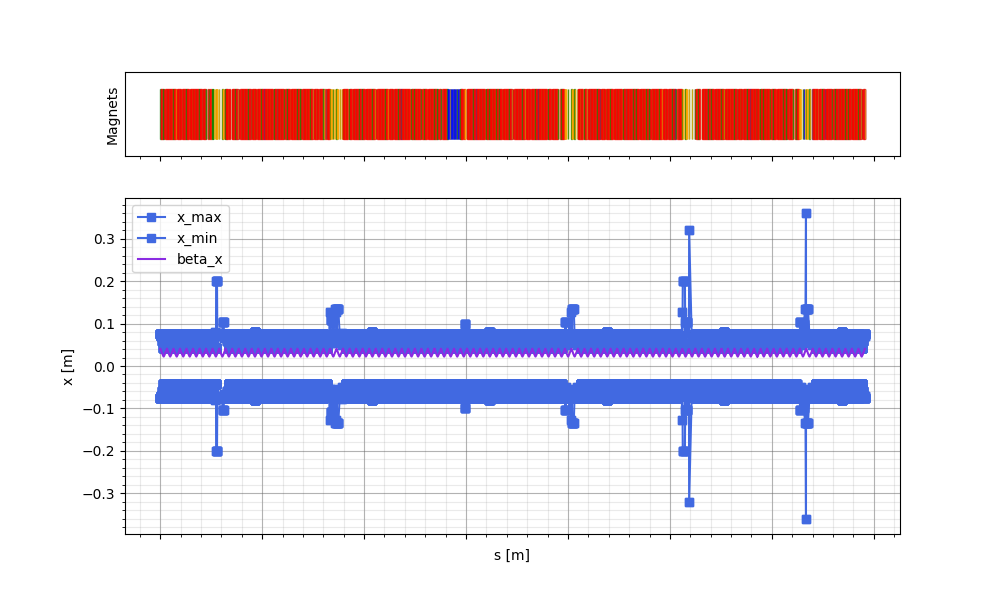

In [61]:
# Create the figure
fig, (ax_top, ax_main) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 4]})

# Scatter-like plots with lines
ax_main.plot(s_arr, x_max_arr, 's-', markersize=5.5, color='royalblue', label="x_max")
ax_main.plot(s_arr, x_min_arr, 's-', markersize=5.5, color='royalblue', label="x_min")
ax_main.plot(tw.s, 10*np.sqrt(tw.betx*exn*pmass/nrj), color='blueviolet', label='beta_x')

# Enable interactive mode
plt.minorticks_on()
plt.xlabel("s [m]")
plt.ylabel("x [m]")
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.grid(visible=True, which='major', color='#666666', linestyle='-', alpha=0.5)

ax_top.set_ylim(0, 1)  # Define space for thick elements
ax_top.set_yticks([])  # Hide y-axis labels
ax_top.set_xticklabels([])  # Hide x labels to make it cleaner
ax_top.set_ylabel("Magnets")

for i in range(len(tab_thick_restr.element_type[mask_thick])):
    name = tab_thick_restr.name[mask_thick][i]
    s_start = tab_thick_restr.s_start[mask_thick][i]
    s_end = tab_thick_restr.s_end[mask_thick][i]
    element_type = tab_thick_restr.element_type[mask_thick][i]
    color = thick_elements_colors[element_type]
    
    width = s_end - s_start
    rect = patches.Rectangle((s_start, 0.2), width, 0.6, edgecolor=color, facecolor=color, alpha=0.7, label=name)
    ax_top.add_patch(rect)

# Convert data coordinates to display (pixel) coordinates
def get_display_coords(x_data, y_data):
    return ax_main.transData.transform(np.vstack([x_data, y_data]).T)

# Click event function
def on_click(event):
    if event.xdata is None or event.ydata is None:
        return  # Ignore clicks outside the plot area

    # Convert clicked position to display coordinates
    click_x, click_y = event.x, event.y

    # Convert data points to pixel coordinates
    display_coords_max = get_display_coords(s_arr, x_max_arr)
    display_coords_min = get_display_coords(s_arr, x_min_arr)

    # Stack all points together
    all_coords = np.vstack([display_coords_max, display_coords_min])
    indices = np.hstack([np.arange(len(s_arr)), np.arange(len(s_arr))])  # Keep track of which index it belongs to
    dataset_labels = np.hstack(["max"] * len(s_arr) + ["min"] * len(s_arr))  # Label the source (max or min)

    # Find closest point in pixel coordinates
    distances = np.sqrt((all_coords[:, 0] - click_x) ** 2 + (all_coords[:, 1] - click_y) ** 2)
    min_index = np.argmin(distances)
    
    # Define a sensitivity threshold (in pixels)
    sensitivity = 10  # Adjust if needed

    if distances[min_index] < sensitivity:
        # Remove previous annotations
        for annotation in reversed(ax_main.texts):
            annotation.remove()

        # Get current zoom level
        x_range = ax_main.get_xlim()
        y_range = ax_main.get_ylim()
        
        # Calculate adaptive offsets based on zoom level
        x_offset = (x_range[1] - x_range[0]) * 0.02  # 2% of x-axis range
        y_offset = (y_range[1] - y_range[0]) * 0.02  # 2% of y-axis range

        # Determine whether it's from x_max or x_min
        original_index = indices[min_index]
        dataset = dataset_labels[min_index]
        y_value = x_max_arr[original_index] if dataset == "max" else x_min_arr[original_index]
        color = "blue" if dataset == "max" else "red"

        # Annotate the closest point
        ax_main.annotate(f"{names_arr[original_index]} ({dataset})\n(s={s_arr[original_index]:.2f}, x={y_value:.2f})",
                    xy=(s_arr[original_index], y_value),
                    xytext=(s_arr[original_index] + x_offset, y_value + y_offset),
                    bbox=dict(facecolor='yellow', edgecolor='black', alpha=0.7),
                    arrowprops=dict(facecolor=color, arrowstyle="->"))
        fig.canvas.draw_idle()

# Function to update elements on zoom
"""
def on_zoom(event):
    # Temporarily disable callback to prevent recursion
    ax_main.callbacks.disconnect(on_zoom.cid)
    
    x_min, x_max = ax_main.get_xlim()
    ax_top.set_xlim(x_min, x_max)

    # Reconnect callback
    on_zoom.cid = ax_main.callbacks.connect('xlim_changed', on_zoom)

    fig.canvas.draw_idle()
    """
def on_zoom(*args):  # No event needed, so we replace it with *args
    ax_main.callbacks.disconnect(on_zoom.cid)  # Prevent infinite recursion

    x_min, x_max = ax_main.get_xlim()
    ax_top.set_xlim(x_min, x_max)

    on_zoom.cid = ax_main.callbacks.connect('xlim_changed', on_zoom)  # Reconnect callback
    fig.canvas.draw_idle()
    
def format_coord(x, y):
    return f"s = {x:.2f}, x = {y:.2f}"

# Connect click event to the figure
fig.canvas.mpl_connect('button_press_event', on_click)
on_zoom.cid = ax_main.callbacks.connect('xlim_changed', on_zoom)
ax_main.format_coord = format_coord

plt.legend()
plt.show()

In [64]:
patches.Rectangle?

Init signature:
patches.Rectangle(
    xy,
    width,
    height,
    *,
    angle=0.0,
    rotation_point='xy',
    **kwargs,
)
Docstring:     
A rectangle defined via an anchor point *xy* and its *width* and *height*.

The rectangle extends from ``xy[0]`` to ``xy[0] + width`` in x-direction
and from ``xy[1]`` to ``xy[1] + height`` in y-direction. ::

  :                +------------------+
  :                |                  |
  :              height               |
  :                |                  |
  :               (xy)---- width -----+

One may picture *xy* as the bottom left corner, but which corner *xy* is
actually depends on the direction of the axis and the sign of *width*
and *height*; e.g. *xy* would be the bottom right corner if the x-axis
was inverted or if *width* was negative.
Init docstring:
Parameters
----------
xy : (float, float)
    The anchor point.
width : float
    Rectangle width.
height : float
    Rectangle height.
angle : float, default: 0
    Rotatio

In [92]:
s_starts = tab_thick.s_start[mask_thick]
s_centers = tab_thick.s_center[mask_thick]
s_ends = tab_thick.s_end[mask_thick]
magnet_names = tab_thick.name[mask_thick]

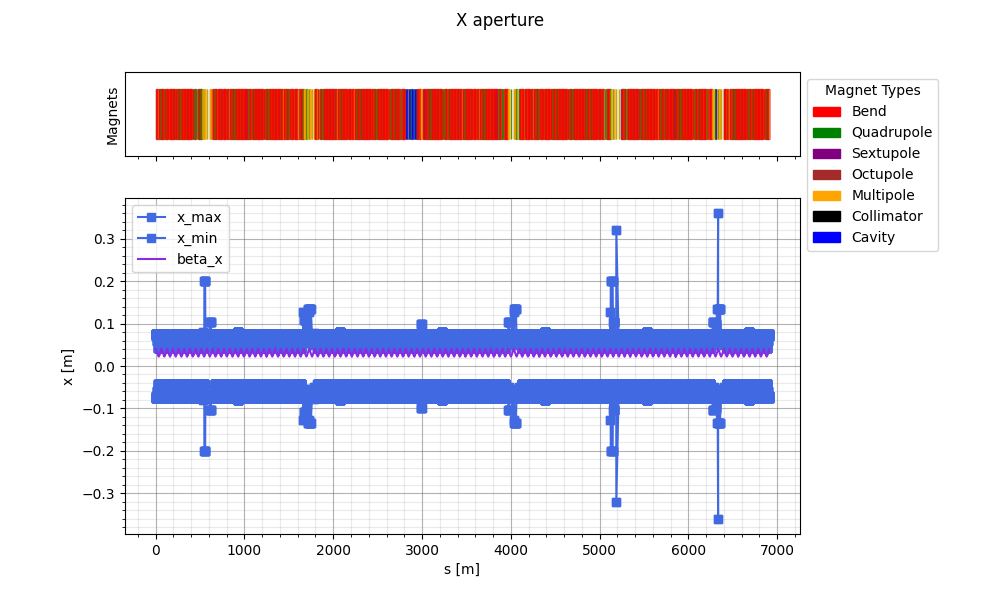

In [140]:
fig, (ax_magnet, ax_ap) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 4]})

#Plot aperture
ax_ap.plot(s_arr, x_max_arr, 's-', markersize=5.5, color='royalblue', label="x_max")
ax_ap.plot(s_arr, x_min_arr, 's-', markersize=5.5, color='royalblue', label="x_min")
ax_ap.plot(tw.s, 10*np.sqrt(tw.betx*exn*pmass/nrj), color='blueviolet', label='beta_x')

# Enable interactive mode
plt.minorticks_on()
plt.xlabel("s [m]")
plt.ylabel("x [m]")
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.grid(visible=True, which='major', color='#666666', linestyle='-', alpha=0.5)


#Plot thick elements
ax_magnet.set_ylim(0, 1)  # Define space for thick elements
ax_magnet.set_yticks([])  # Hide y-axis labels
ax_magnet.set_xticklabels([])  # Hide x labels to make it cleaner
ax_magnet.set_ylabel("Magnets")

for i in range(len(tab_thick_restr.element_type[mask_thick])):
    name = tab_thick_restr.name[mask_thick][i]
    s_start = tab_thick_restr.s_start[mask_thick][i]
    s_end = tab_thick_restr.s_end[mask_thick][i]
    element_type = tab_thick_restr.element_type[mask_thick][i]
    color = thick_elements_colors[element_type]
    
    width = s_end - s_start
    rect = patches.Rectangle((s_start, 0.2), width, 0.6, edgecolor=color, facecolor=color, alpha=0.7, label=name)
    ax_magnet.add_patch(rect)

# Convert data coordinates to display (pixel) coordinates
def get_display_coords(x_data, y_data):
    return ax_ap.transData.transform(np.vstack([x_data, y_data]).T)

def on_click(event):
    if event.xdata is None or event.ydata is None:
        return  # Ignore clicks outside the plot area
    
    if event.inaxes == ax_magnet:
        click_x = event.xdata
        
        # Remove previous annotations
        for annotation in reversed(ax_magnet.texts):
            annotation.remove()
        
        # Find the closest magnet
        distances = np.abs(s_centers - click_x)
        min_index = np.argmin(distances)
        
        
        sensitivity = 0.5  # Adjust if needed
        
        
        if click_x >= s_starts[min_index]-sensitivity and click_x <= s_ends[min_index]+sensitivity:
            index = min_index
        
        elif min_index > 0 and click_x >= s_starts[min_index-1]-sensitivity and click_x <= s_ends[min_index-1]+sensitivity:
            index = min_index-1
        
        elif min_index < len(s_centers) - 1 and click_x >= s_starts[min_index+1]-sensitivity and click_x <= s_ends[min_index+1]+sensitivity:
            index = min_index+1
        
        else:
            return # Ignore clicks outside the magnet area
        
        # Annotate the clicked magnet
        ax_magnet.annotate(f"{magnet_names[index]}\ns = {s_centers[index]:.2f} m",
                        xy=(s_centers[index], 0.95),
                        xytext=(s_centers[index], 0.999),
                        ha="center", fontsize=10, color="black",
                        bbox=dict(facecolor="yellow", edgecolor="black", alpha=0.7),
                        arrowprops=dict(facecolor="black", arrowstyle="->"))
        
        fig.canvas.draw_idle()  # Update the figure
    
    if event.inaxes == ax_ap:
        # Convert clicked position to display coordinates
        click_x, click_y = event.x, event.y
        
        # Convert data points to pixel coordinates
        display_coords_max = get_display_coords(s_arr, x_max_arr)
        display_coords_min = get_display_coords(s_arr, x_min_arr)

        # Stack all points together
        all_coords = np.vstack([display_coords_max, display_coords_min])
        indices = np.hstack([np.arange(len(s_arr)), np.arange(len(s_arr))])  # Keep track of which index it belongs to
        dataset_labels = np.hstack(["max"] * len(s_arr) + ["min"] * len(s_arr))  # Label the source (max or min)

        # Find closest point in pixel coordinates
        distances = np.sqrt((all_coords[:, 0] - click_x) ** 2 + (all_coords[:, 1] - click_y) ** 2)
        min_index = np.argmin(distances)
        
        # Define a sensitivity threshold (in pixels)
        sensitivity = 10  # Adjust if needed

        if distances[min_index] < sensitivity:
            # Remove previous annotations
            for annotation in reversed(ax_ap.texts):
                annotation.remove()

            # Get current zoom level
            x_range = ax_ap.get_xlim()
            y_range = ax_ap.get_ylim()
            
            # Calculate adaptive offsets based on zoom level
            x_offset = (x_range[1] - x_range[0]) * 0.02  # 2% of x-axis range
            y_offset = (y_range[1] - y_range[0]) * 0.02  # 2% of y-axis range

            # Determine whether it's from x_max or x_min
            original_index = indices[min_index]
            dataset = dataset_labels[min_index]
            y_value = x_max_arr[original_index] if dataset == "max" else x_min_arr[original_index]
            color = "blue" if dataset == "max" else "red"

            # Annotate the closest point
            ax_ap.annotate(f"{names_arr[original_index]} ({dataset})\n(s={s_arr[original_index]:.2f}, x={y_value:.2f})",
                        xy=(s_arr[original_index], y_value),
                        xytext=(s_arr[original_index] + x_offset, y_value + y_offset),
                        bbox=dict(facecolor='yellow', edgecolor='black', alpha=0.7),
                        arrowprops=dict(facecolor=color, arrowstyle="->"))
            fig.canvas.draw_idle()
            
def on_zoom(event):
    # Temporarily disable callback to prevent recursion
    ax_ap.callbacks.disconnect(on_zoom.cid)
    
    x_min, x_max = ax_ap.get_xlim()
    ax_magnet.set_xlim(x_min, x_max)

    #ax_magnet.set_xticks(ax_ap.get_xticks())  # Copy x-ticks from main plot
    #ax_magnet.set_xticklabels(ax_ap.get_xticklabels())
    update_xticks(event)
    # Reconnect callback
    on_zoom.cid = ax_ap.callbacks.connect('xlim_changed', on_zoom)

    fig.canvas.draw_idle()
    
def format_coord(x, y):
    return f"s = {x:.2f}, x = {y:.2f}"

def update_xticks(event):
    """ Update x-ticks dynamically based on zooming/panning. """
    x_min, x_max = event.get_xlim()
    
    # Use MaxNLocator to find reasonable tick positions (e.g., multiples of 10, 50, etc.)
    locator = ticker.MaxNLocator(nbins=10, integer=True, prune="both")  # Adjust nbins if needed
    xticks = locator.tick_values(x_min, x_max)

    # Update ticks and labels
    ax_ap.set_xticks(xticks)
    ax_ap.set_xticklabels([f"{tick:.0f}" for tick in xticks]) 
    #ax_ap.figure.canvas.draw_idle()


# Connect click event to the figure
fig.canvas.mpl_connect('button_press_event', on_click)
on_zoom.cid = ax_ap.callbacks.connect('xlim_changed', on_zoom)
ax_ap.format_coord = format_coord
ax_magnet.format_coord = format_coord

# Create legend patches
legend_patches = [patches.Patch(color=color, label=element) for element, color in thick_elements_colors.items()]

# Add the legend outside the main plot
ax_magnet.legend(handles=legend_patches, loc="upper left", bbox_to_anchor=(1, 1), title="Magnet Types", fontsize=10)
fig.subplots_adjust(right=0.8)

xticks = np.linspace(0, 7000, num=8)
ax_ap.set_xticks(xticks)
ax_ap.set_xticklabels([f"{int(tick)}" for tick in xticks])

plt.suptitle('X aperture')
plt.legend()
plt.show()

In [89]:
s_start

np.float64(6910.983799999835)